In [1]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from typing import Annotated
import json
from langchain_core.messages import ToolMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
load_dotenv()

True

### Define the web search tool:

In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]

In [3]:
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.langchain.dev/langgraph/',
   'title': 'LangGraph - LangChain Blog',
   'content': "TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. The state of this graph by default contains concepts that should be familiar to you if you've used LangChain agents: `input`, `chat_history`, `intermediate_steps` (and `agent_outcome` to represent the most recent agent outcome)",
   'score': 0.7407191,
   'raw_content': None},
  {'url': 'https://medium.com/@cplog/introduction

In [4]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
graph_builder = StateGraph(State)

In [7]:
llm_with_tools = llm.bind_tools(tools)

In [8]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [9]:
graph_builder.add_node("chatbot", chatbot)

### Creating BasicNode class to call tools

In [10]:
class BasicToolNode:
    """A node that runs the tools requested in th elast AImessage """
    def __init__(self,tools: list) -> None:
        self.tools_by_name = {tool.name: tool in tools}
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else: 
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
tool_node = BasicToolNode(tools=[tool])

graph_builder.add_node("tools", tool_node)

### conditional_edges

The condition will route to tools if tool calls are present and END if not. Because the condition can return END

In [11]:
def route_tools(state: State):
    """
        Route to toolNode if last message has tool call, otherwise route 
        to the end
    Args:
        state (State): graph's State
    """
    if isinstance(state,list):
        ai_message = state[-1]
    elif messages := state.get("messages",[]):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No message found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls)>0:
        return "tools"
    return END

In [12]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools":"tools",END:END}
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

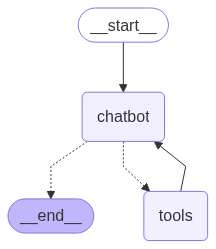

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [15]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

c:\Users\FADEL\Documents\GitHub\langchain\project\langgraph-api\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:1568: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


User: What do you know about LangGraph?
Assistant: 


AttributeError: 'bool' object has no attribute 'invoke'